In [3]:
import numpy as np
import networkx as nx
import skimage.io as skio
import skimage.util as sku
from sklearn.metrics import adjusted_rand_score

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

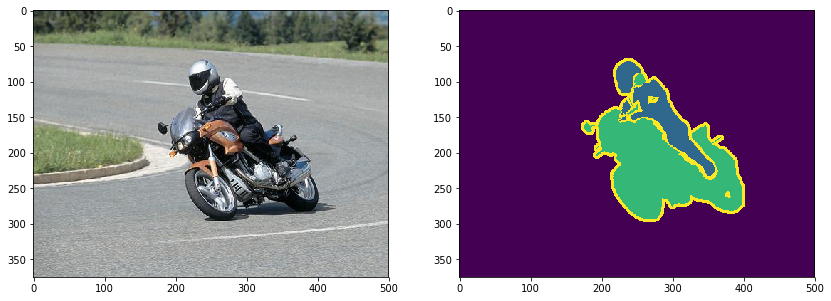

In [5]:
img = sku.img_as_float(skio.imread("moto.jpg"))

seg_orig = skio.imread("moto_seg.png")
_, true_seg = np.unique(seg_orig.reshape(-1, 3), axis=0, return_inverse=True)
true_seg = true_seg.reshape(seg_orig.shape[:2])

_, (left, right) = plt.subplots(1, 2)
right.imshow(true_seg);
left.imshow(img);

In [6]:
import skimage.segmentation as seg

In [7]:
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

In [8]:
def hufbauer_alpha(image, labels, connectivity=2):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'total brightness': 0,
                            'total pixels': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['total pixels'] += 1
        rag.node[current]['total brightness'] += np.sqrt(np.dot(image[index], image[index])) / np.sqrt(3)
        if rag.node[current]['total brightness'] > rag.node[current]['total pixels']:
            print(np.sqrt(np.dot(image[index], image[index])) / np.sqrt(3))
    
    for n in rag:
        rag.node[n]['total brightness'] /= rag.node[n]['total pixels']

    for x, y, d in rag.edges(data=True):
        d['weight'] = 2 / (1 + np.abs(rag.node[x]['total brightness'] - rag.node[y]['total brightness'])) - 1
#         if d['weight'] < 0.6:
#             d['weight'] = 0

    return rag

In [9]:
def hufbauer_beta(image, labels, connectivity=2):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'total brightness': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        color = image[index] - [0.5, 0.5, 0.5]
        rag.node[current]['total brightness'] += np.sqrt(np.dot(color, color))
        rag.node[current]['total color'] += color

    for n in rag:
        rag.node[n]['total color'] *= 1.0 / rag.node[n]['total brightness']

    for x, y, d in rag.edges(data=True):
        d['weight'] = (1 + np.dot(rag.node[x]['total color'], rag.node[y]['total color'])) / 2
#         if d['weight'] < 0.6:
#             d['weight'] = 0

    return rag

In [10]:
def rag_val(g):
    values = []
    for _, _, d in g.edges(data=True):
        values.append(d["weight"])
    return values

In [11]:
sps = seg.slic(img, slic_zero=True)
rag_a = hufbauer_alpha(img, sps)
rag_b = hufbauer_beta(img, sps)

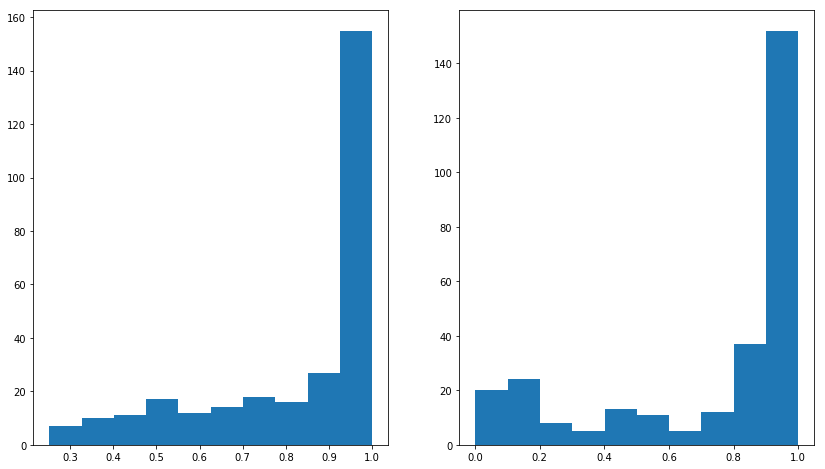

In [12]:
_, (l, r) = plt.subplots(1, 2)
l.hist(rag_val(rag_a))
r.hist(rag_val(rag_b))
plt.show()

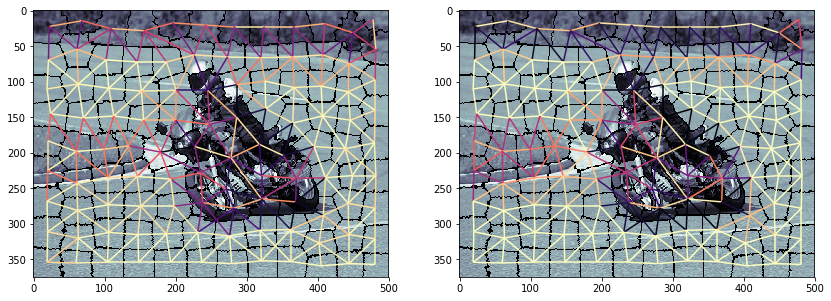

In [13]:
_, (l, r) = plt.subplots(1, 2)
graph.show_rag(sps, rag_a, img, ax=l)
graph.show_rag(sps, rag_b, img, ax=r)

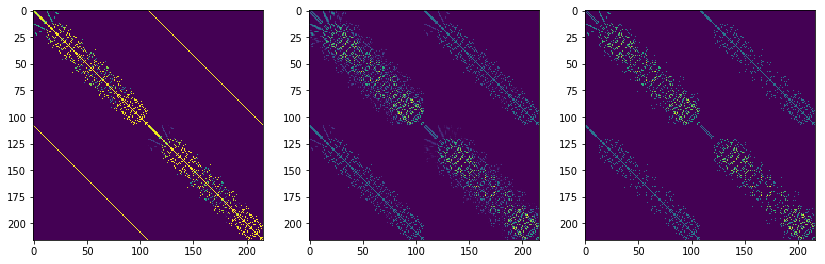

In [14]:
sps = seg.slic(img, slic_zero=True)
num_sps = sps.max() + 1

adj_a = nx.adjacency_matrix(rag_a).todense()
adj_b = nx.adjacency_matrix(rag_b).todense()

adj = np.c_[
    np.r_[
        adj_a, 
        np.diag(np.ones(num_sps)),
    ],
    np.r_[
        np.diag(np.ones(num_sps)),
        adj_b,
    ],
]
np.fill_diagonal(adj, 1)
adj_b = np.copy(adj)
_, (l, m, r) = plt.subplots(1, 3)
l.imshow(adj)
adj = adj ** 2
np.fill_diagonal(adj, 0)
m.imshow(adj)
adj[adj < np.percentile(adj[adj > 0], 50)] = 0
r.imshow(adj)

In [91]:
import dynSIS
import importlib
importlib.reload(dynSIS)

<module 'dynSIS' from '/Users/emory/Desktop/587/image_seg_interdep_epidemic/src/notebooks/dynSIS.py'>

In [92]:
def score(prop):
    return adjusted_rand_score(true_seg.flat, prop.flatten())

In [97]:
def heuristic(prop):
    p = np.copy(prop)
    p[p >= 1] = 2
    return -np.sum(p * adj_b)

In [98]:
# Run it through the simulator
proposals = dynSIS.dyn_run(nx.Graph(adj), samples=16, run_time=20, init=1)
# Extract the data
proposals = np.array([np.fromiter(prop.values(), dtype=float) for prop in proposals])

In [99]:
# Take the best segmentation
order = np.argsort(np.apply_along_axis(heuristic, 1, proposals))
order

array([ 5, 15, 14,  0,  4,  9, 12,  3,  8, 13,  2,  6,  1, 11,  7, 10])

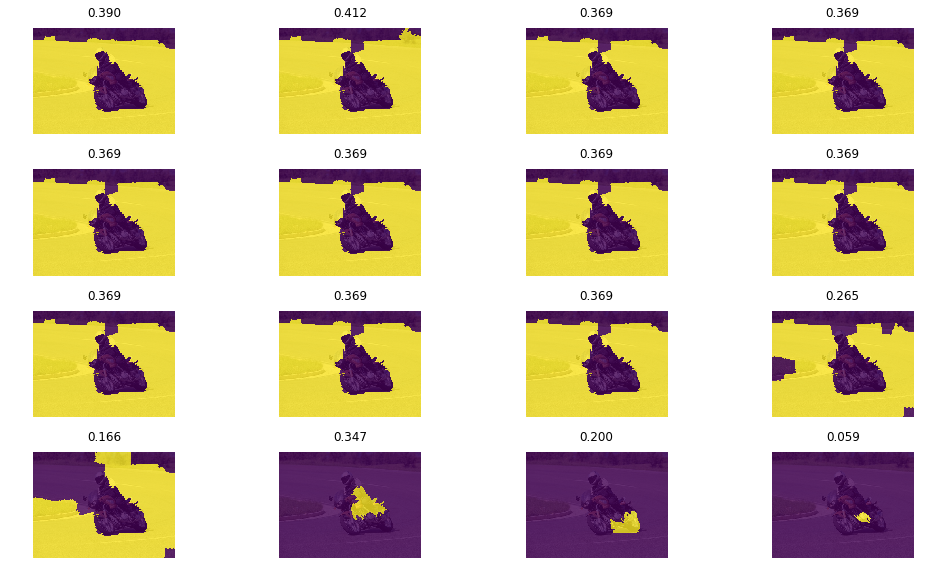

In [100]:
# Draw it
_, axs = plt.subplots(4,4)
for bar, ax in zip(order, axs.flat):
    proposal = sum(np.array(np.split(proposals[bar], 2)))
    proposal[proposal > 1] = 1
    ax.matshow(proposal[sps])
    ax.imshow(img, alpha=0.2)
    ax.set_title("{:.3f}".format(score(proposal[sps])))
    ax.set_axis_off()

plt.tight_layout();